In [2]:
pip install tensorflow keras numpy matplotlib opencv-python kaggle

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers, applications, regularizers

In [21]:
data_dir = "E:\Surf\BINUS\LAB\OralAppsV2\data"

In [22]:
if not os.path.exists(data_dir):
    raise ValueError("Data directory not found")

In [23]:
dataset = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    batch_size=32,
    image_size=(150, 150)
)

Found 1050 files belonging to 8 classes.


In [24]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)  

In [25]:
data_augmentation = keras.Sequential(
    [   
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2)
    ])

In [26]:
def preprocess_image(image, label):
    image = data_augmentation(image) # Apply augmentation
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

In [27]:
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)

In [28]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(dataset.class_names), activation='softmax')
])

In [30]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
epochs_cnn = 100
history_cnn = cnn_model.fit(
    train_ds,
    epochs=epochs_cnn,
    validation_data=val_ds
)

Epoch 1/100
26/26 [==============================] - 7s 212ms/step - loss: 2.0987 - accuracy: 0.1202 - val_loss: 2.0469 - val_accuracy: 0.2615
Epoch 2/100
26/26 [==============================] - 6s 209ms/step - loss: 2.0086 - accuracy: 0.2608 - val_loss: 1.9041 - val_accuracy: 0.3303
Epoch 3/100
26/26 [==============================] - 6s 219ms/step - loss: 1.8565 - accuracy: 0.3257 - val_loss: 1.6761 - val_accuracy: 0.4174
Epoch 4/100
26/26 [==============================] - 6s 220ms/step - loss: 1.6626 - accuracy: 0.3678 - val_loss: 1.5061 - val_accuracy: 0.4817
Epoch 5/100
26/26 [==============================] - 6s 225ms/step - loss: 1.5462 - accuracy: 0.4255 - val_loss: 1.5170 - val_accuracy: 0.4312
Epoch 6/100
26/26 [==============================] - 6s 221ms/step - loss: 1.4530 - accuracy: 0.4700 - val_loss: 1.3098 - val_accuracy: 0.5550
Epoch 7/100
26/26 [==============================] - 6s 226ms/step - loss: 1.3951 - accuracy: 0.4748 - val_loss: 1.3709 - val_accuracy: 0.5046

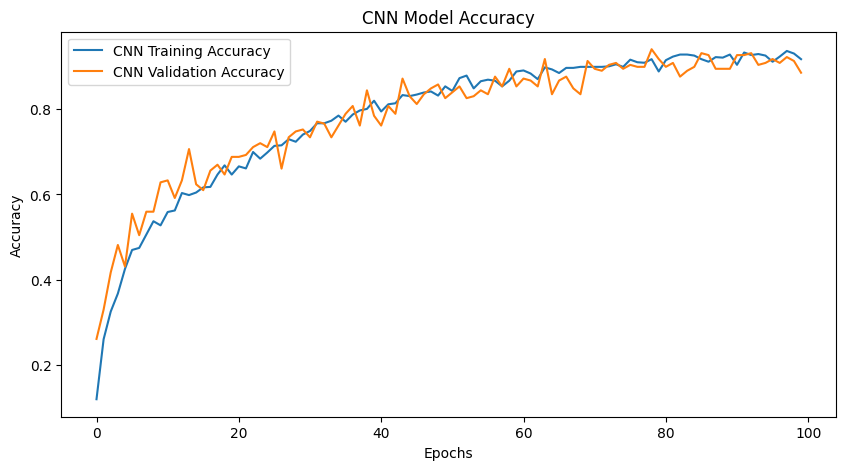

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['accuracy'], label='CNN Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Model Accuracy')
plt.show()

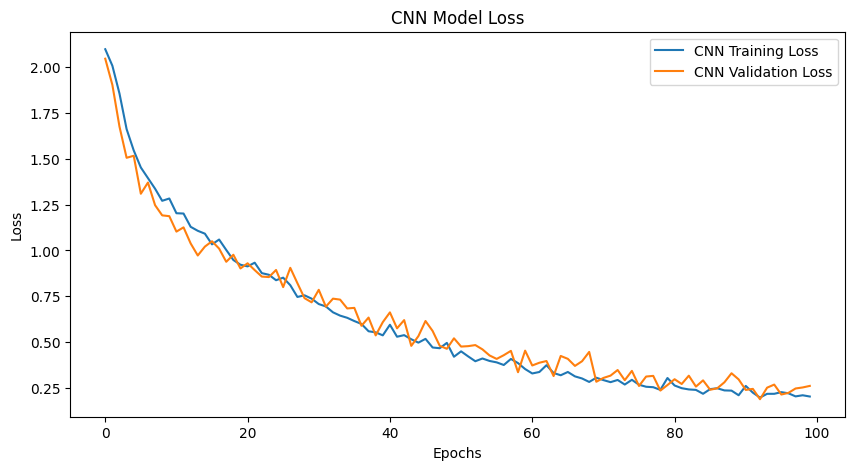

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['loss'], label='CNN Training Loss')
plt.plot(history_cnn.history['val_loss'], label='CNN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Model Loss')
plt.show()

In [ ]:
base_model = tf.keras.applications.Xception(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [50]:
transfer_model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(dataset.class_names), activation='softmax')
])

In [51]:
transfer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [52]:
transfer_history = transfer_model.fit(train_ds, validation_data=val_ds, epochs=epochs_cnn)

Epoch 1/100
26/26 [==============================] - 15s 476ms/step - loss: 1.6242 - accuracy: 0.4087 - val_loss: 1.0765 - val_accuracy: 0.5642
Epoch 2/100
26/26 [==============================] - 13s 492ms/step - loss: 1.0392 - accuracy: 0.6262 - val_loss: 0.9212 - val_accuracy: 0.6697
Epoch 3/100
26/26 [==============================] - 13s 501ms/step - loss: 0.8802 - accuracy: 0.6719 - val_loss: 0.7420 - val_accuracy: 0.7110
Epoch 4/100
26/26 [==============================] - 13s 505ms/step - loss: 0.7864 - accuracy: 0.7079 - val_loss: 0.7887 - val_accuracy: 0.7202
Epoch 5/100
26/26 [==============================] - 13s 500ms/step - loss: 0.6712 - accuracy: 0.7476 - val_loss: 0.6937 - val_accuracy: 0.7248
Epoch 6/100
26/26 [==============================] - 13s 505ms/step - loss: 0.6654 - accuracy: 0.7488 - val_loss: 0.5928 - val_accuracy: 0.7982
Epoch 7/100
26/26 [==============================] - 13s 503ms/step - loss: 0.6222 - accuracy: 0.7668 - val_loss: 0.7328 - val_accuracy:

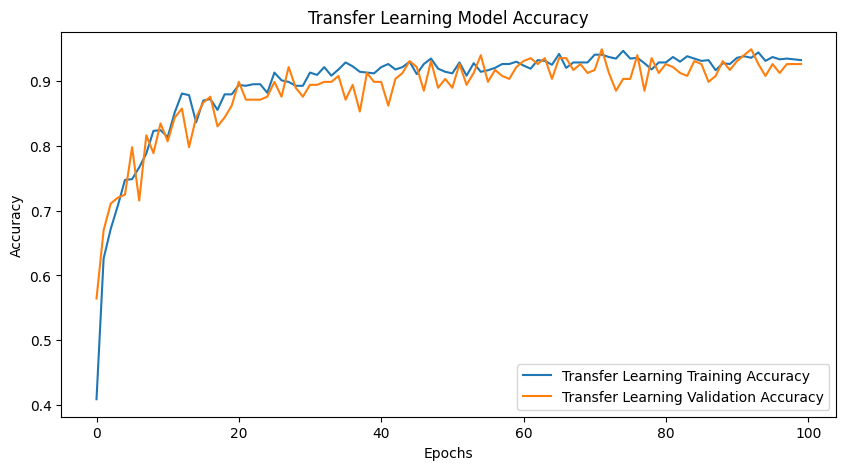

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(transfer_history.history['accuracy'], label='Transfer Learning Training Accuracy')
plt.plot(transfer_history.history['val_accuracy'], label='Transfer Learning Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Transfer Learning Model Accuracy')
plt.show()

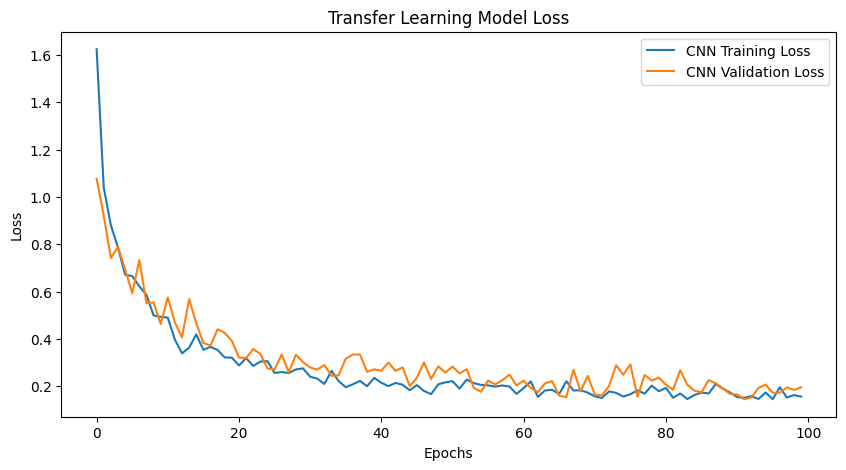

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(transfer_history.history['loss'], label='CNN Training Loss')
plt.plot(transfer_history.history['val_loss'], label='CNN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Transfer Learning Model Loss')
plt.show()

In [55]:
cnn_model.save(os.path.join(data_dir, "cnn_mouth_disease_model.h5"))
transfer_model.save(os.path.join(data_dir, "transfer_mouth_disease_model.h5"))

c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_cnn_model = converter.convert()
with open(os.path.join(data_dir, "cnn_mouth_disease_model.tflite"), "wb") as f:
    f.write(tflite_cnn_model)

INFO:tensorflow:Assets written to: C:\Users\INTEL\AppData\Local\Temp\tmpvjix9asw\assets


INFO:tensorflow:Assets written to: C:\Users\INTEL\AppData\Local\Temp\tmpvjix9asw\assets


In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(transfer_model)
tflite_transfer_model = converter.convert()
with open(os.path.join(data_dir, "transfer_mouth_disease_model.tflite"), "wb") as f:
    f.write(tflite_transfer_model)

print("Both CNN and Transfer Learning models have been converted to TensorFlow Lite!")


INFO:tensorflow:Assets written to: C:\Users\INTEL\AppData\Local\Temp\tmptopvg8ox\assets


INFO:tensorflow:Assets written to: C:\Users\INTEL\AppData\Local\Temp\tmptopvg8ox\assets


Both CNN and Transfer Learning models have been converted to TensorFlow Lite!


In [58]:
def predict_image(model_path, image_path):
    from tensorflow.keras.preprocessing import image  # Ensure image module is imported
    model = keras.models.load_model(model_path)
    img = image.load_img(image_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_name = dataset.class_names[class_index]
    print(f"Predicted class: {class_name}")

In [59]:
def test_transfer_model():
    test_loss, test_acc = transfer_model.evaluate(val_ds)
    print(f'Transfer Learning Model Test Accuracy: {test_acc:.4f}')


In [60]:
def test_cnn_model():
    test_loss, test_acc = cnn_model.evaluate(val_ds)
    print(f'CNN Model Test Accuracy: {test_acc:.4f}')

In [61]:
test_cnn_model()

7/7 [==============================] - 1s 69ms/step - loss: 0.2418 - accuracy: 0.9312
CNN Model Test Accuracy: 0.9312


In [62]:
test_transfer_model()

7/7 [==============================] - 3s 317ms/step - loss: 0.1796 - accuracy: 0.9358
Transfer Learning Model Test Accuracy: 0.9358


In [65]:
predict_image('E:\Surf\BINUS\LAB\OralAppsV2\data/transfer_mouth_disease_model.h5','E:\Surf\BINUS\LAB\OralAppsV2\pest4.jpg')

ValueError: in user code:

    File "c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(None, 200, 200, 3)
